In [1]:
%env TF_CPP_MIN_LOG_LEVEL=3

import tensorflow as tf # type: ignore
from tensorflow.keras.preprocessing import image_dataset_from_directory # type: ignore 
from tensorflow.keras import layers, models # type: ignore
import os
import matplotlib.pyplot as plt # type: ignore

env: TF_CPP_MIN_LOG_LEVEL=3


In [2]:
train_dataset_directory = "../raw/"
test_dataset_directorry = "../raw_to_test/"

img_size = (150, 150)
batch_size = 32
validation_split = 0.2

In [8]:
train_dataset = image_dataset_from_directory(
    train_dataset_directory,
    labels='inferred',  # inferred from the directory structure
    label_mode='int', # encoded as integer
    batch_size=batch_size, 
    image_size=img_size, 
    shuffle=True,
    seed=42,
    validation_split=validation_split,
    subset="training"
)

validation_dataset = image_dataset_from_directory(
    train_dataset_directory,
    labels='inferred', 
    label_mode='int',
    batch_size=batch_size,
    image_size=img_size,
    shuffle=True,
    seed=42,
    validation_split=validation_split,
    subset="validation"
)

test_dataset = image_dataset_from_directory(
    test_dataset_directorry,
    labels='inferred',
    label_mode='int',
    batch_size=batch_size,
    image_size=img_size,
    shuffle=True,
    seed=42
)

Found 5433 files belonging to 3 classes.
Using 4347 files for training.
Found 5433 files belonging to 3 classes.
Using 1086 files for validation.
Found 1406 files belonging to 3 classes.


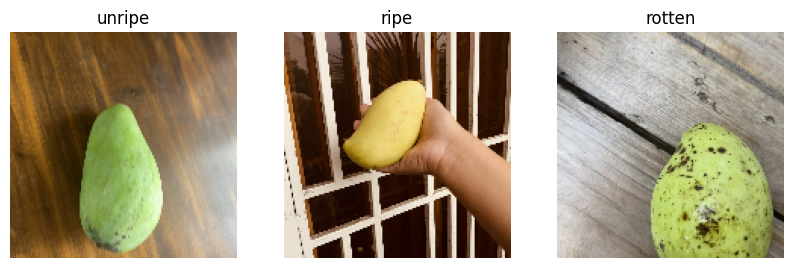

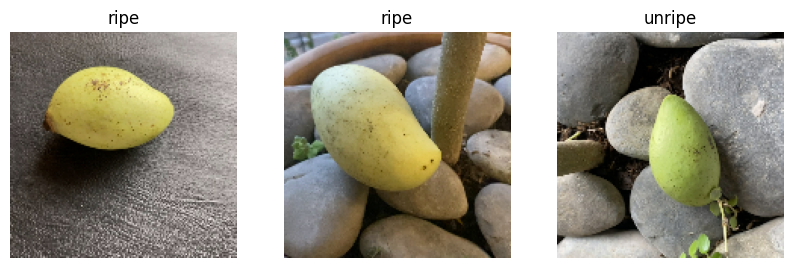

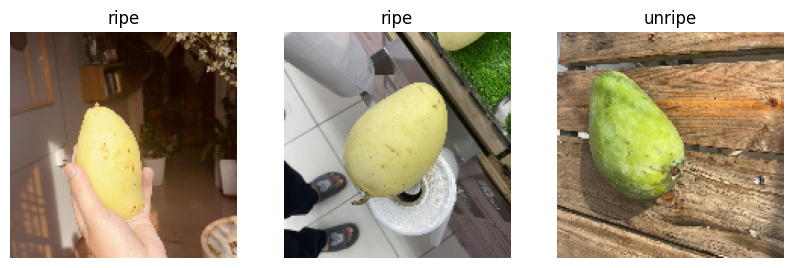

In [9]:
import matplotlib.pyplot as plt

def display_images(dataset, num_images=9):
    class_names = dataset.class_names 
    plt.figure(figsize=(10, 10))
    for images, labels in dataset.take(1): 
        for i in range(num_images):
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(images[i].numpy().astype("uint8"))
            plt.title(class_names[int(labels[i])])
            plt.axis("off")
    plt.show()

display_images(train_dataset, num_images=3)
display_images(validation_dataset, num_images=3)
display_images(test_dataset, num_images=3)

In [10]:
print(f'Number of Train batches: {len(train_dataset)}')
print(f'Number of  Validation batches: {len(validation_dataset)}')
print(f'Number of  Test batches: {len(test_dataset)}')

Number of Train batches: 136
Number of  Validation batches: 34
Number of  Test batches: 44


In [11]:
input_shape = img_size + (3,)
class_numbers = len(train_dataset.class_names)
print(f'Input shape: {input_shape}')
print(f'Class number: {class_numbers}')

Input shape: (150, 150, 3)
Class number: 3


In [31]:
# Define a CNN model
model = models.Sequential(name='trained_001')
model.add(layers.Input(shape=input_shape))
model.add(layers.Conv2D(32, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D(2, 2))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D(2, 2))


model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(class_numbers, activation='softmax'))  

In [32]:
learning_rate = 0.0001
print(f'Learning rate: {learning_rate}')

Learning rate: 0.0001


In [34]:
from tensorflow.keras import optimizers  # type: ignore

optimizer = optimizers.Adam(learning_rate=learning_rate)

model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "trained_001"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_9 (Conv2D)               │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 82944)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │     5,308,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,328,067 (20.32 MB)

 Trainable params: 5,328,067 (20.32 MB)

 Non-trainable params: 0 (0.00 B)

In [35]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    patience=5,
    restore_best_weights=True
)

In [36]:
# Run a few dummy batches to warm up the GPU
warmup_data = next(iter(train_dataset))
_ = model.predict(warmup_data[0])  # Use predict to trigger the GPU

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 993ms/step


In [37]:
history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=50,
    callbacks=[early_stopping]
)

Epoch 1/50


E0000 00:00:1727594306.344141   29675 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1727594306.624095   29675 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1727594306.886013   29675 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1727594307.168888   29675 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1727594307.442655   29675 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000

135/136 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.6147 - loss: 42.3666

E0000 00:00:1727594323.118331   29675 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1727594323.353661   29675 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


136/136 ━━━━━━━━━━━━━━━━━━━━ 26s 145ms/step - accuracy: 0.6170 - loss: 41.9289 - val_accuracy: 0.9107 - val_loss: 0.4988
Epoch 2/50
136/136 ━━━━━━━━━━━━━━━━━━━━ 14s 103ms/step - accuracy: 0.9362 - loss: 0.3895 - val_accuracy: 0.9945 - val_loss: 0.0181
Epoch 3/50
136/136 ━━━━━━━━━━━━━━━━━━━━ 14s 104ms/step - accuracy: 0.9624 - loss: 0.3043 - val_accuracy: 0.9945 - val_loss: 0.0230
Epoch 4/50
136/136 ━━━━━━━━━━━━━━━━━━━━ 14s 105ms/step - accuracy: 0.9948 - loss: 0.0246 - val_accuracy: 0.9954 - val_loss: 0.0155
Epoch 5/50
136/136 ━━━━━━━━━━━━━━━━━━━━ 16s 116ms/step - accuracy: 0.9985 - loss: 0.0025 - val_accuracy: 0.9991 - val_loss: 0.0041
Epoch 6/50
136/136 ━━━━━━━━━━━━━━━━━━━━ 17s 123ms/step - accuracy: 0.9942 - loss: 0.0189 - val_accuracy: 0.9392 - val_loss: 0.2393
Epoch 7/50
136/136 ━━━━━━━━━━━━━━━━━━━━ 16s 118ms/step - accuracy: 0.9763 - loss: 0.0818 - val_accuracy: 0.9632 - val_loss: 0.2703
Epoch 8/50
136/136 ━━━━━━━━━━━━━━━━━━━━ 15s 106ms/step - accuracy: 0.9768 - loss: 0.1361 - va

In [38]:
model_filename = f'./output/mango_classifier_trained_001.keras'

model.save(model_filename)

print(f'Model saved to {model_filename}')

Model saved to ./output/mango_classifier_trained_001.keras


In [39]:
test_loss, test_acc = model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.4f}")

44/44 ━━━━━━━━━━━━━━━━━━━━ 4s 90ms/step - accuracy: 0.8715 - loss: 1.4334
Test accuracy: 0.8755


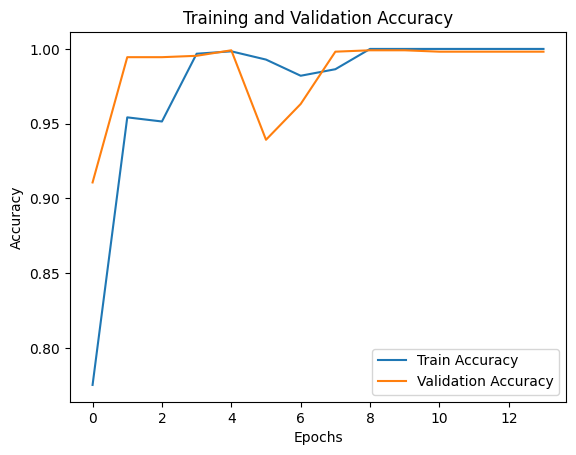

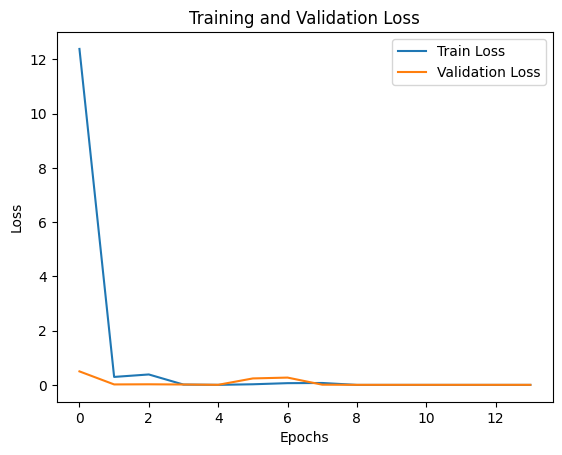

In [40]:
import matplotlib.pyplot as plt # type: ignore

# Plotting accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plotting loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━

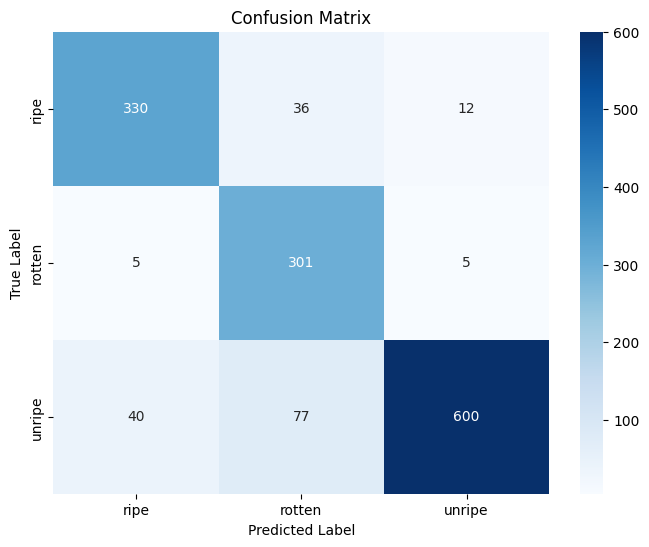

In [41]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

class_labels = ['ripe', 'rotten', 'unripe']

true_labels = []
predicted_labels = []

for images, labels in test_dataset:

    preds = model.predict(images)
    predicted_labels.extend(np.argmax(preds, axis=1)) 
    true_labels.extend(labels.numpy())
cm = confusion_matrix(true_labels, predicted_labels)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


In [42]:
class_labels = ['ripe', 'rotten', 'unripe']


In [43]:
import numpy as np
import random
import matplotlib.pyplot as plt


new_model = tf.keras.models.load_model('./output/mango_classifier_trained5.keras')
class_labels = ['ripe', 'rotten', 'unripe']


def display_random_images_grid(dataset, model, class_labels, grid_size=3):
    plt.figure(figsize=(10, 10))  # Adjust figure size based on grid
    for images, labels in dataset.take(1):  # Take one batch of data
        for i in range(grid_size * grid_size):  # Create a grid of grid_size x grid_size images
            random_index = random.randint(0, len(images) - 1)  # Randomly pick an image

            random_image = images[random_index]
            true_label = labels[random_index].numpy()

            # Make a prediction
            prediction = model.predict(np.expand_dims(random_image, axis=0)) 
            predicted_label = np.argmax(prediction, axis=1)[0]

            # Plot each image in the grid
            ax = plt.subplot(grid_size, grid_size, i + 1)  
            plt.imshow(random_image.numpy().astype("uint8"))
            plt.title(f"Thực tế: {class_labels[true_label]}\nDự đoán: {class_labels[predicted_label]}")
            plt.axis("off")  # Hide the axis

    plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


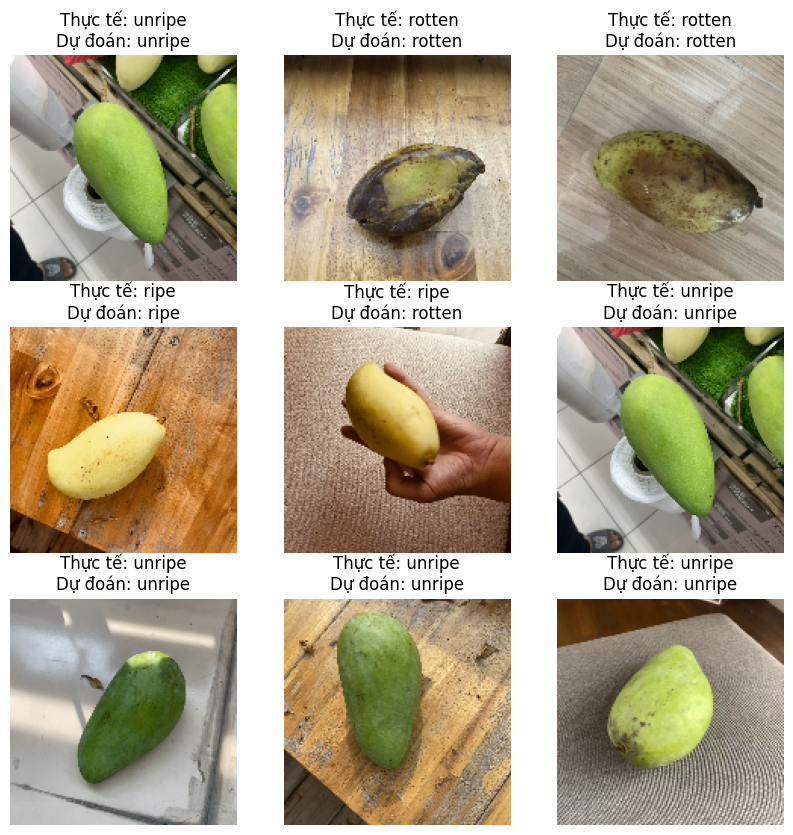

In [45]:
display_random_images_grid(test_dataset, model, class_labels, grid_size=3)